In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import logging
import requests
import datetime as dt
import pylab

import scipy.stats as stats
from matplotlib import pyplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

logging.getLogger().setLevel(logging.INFO)


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os, sys

In [2]:
home = os.environ["HOME"]
sys.path.append(f"{home}/Desktop/project-ursa/lib")

import imp

In [3]:
import monte_carlo
imp.reload(monte_carlo)

import data_utils
imp.reload(data_utils)

# import data_analysis
# imp.reload(data_analysis)

import mining_constants
imp.reload(mining_constants)

import machine_npv
imp.reload(machine_npv)

<module 'machine_npv' from '/Users/merkle-employee/Desktop/project-ursa/lib/machine_npv.py'>

In [4]:
du = data_utils.DataUtility("")
du._raw_network_price_df    = pd.read_csv("../../data/raw_network_price.csv").drop("Unnamed: 0", axis="columns")

du._raw_network_price_df.time = pd.to_datetime(du._raw_network_price_df.time)
du._df_feature() 
du._aggregate_weekly_df() 

machine_prices = data_utils.machine_market_prices("../../data/machine_prices.csv")
du._weekly_machine_price_df = du._join_machine_price(machine_prices, HR_ROLLING_AVG=30)

weekly_df = du._weekly_network_price_df
machine_df = du._weekly_machine_price_df

In [8]:
machine_df.head()

,close,hashrate,S9,S17,S19J,M20,M30
time,,,,,,,
2020-03-01,8549.38,1.121475e+08,86.0,1371.0,2398.0,1580.0,2593.0
2020-03-08,8057.67,1.146175e+08,86.0,1371.0,2398.0,1580.0,2593.0
2020-03-15,5357.02,1.149130e+08,86.0,1371.0,2398.0,1580.0,2593.0
2020-03-22,5828.15,1.110932e+08,86.0,1371.0,2398.0,1580.0,2593.0
2020-03-29,5882.20,1.075877e+08,86.0,1371.0,2398.0,1580.0,2593.0


In [19]:
# weekly_df.head()

k = 12

machine_df.reset_index().loc[k]

time        2020-05-24 00:00:00
close                   8718.49
hashrate        108207711.33243
S9                         47.0
S17                      1432.0
S19J                     2220.0
M20                      1550.0
M30                      2199.0
Name: 12, dtype: object

In [6]:
## 
sp = monte_carlo.GBMPriceLinearHashRate()
sp.fit(weekly_df, sample_rate=mining_constants.SAMPLE_RATE_WEEKLY)

## 
k = 134

start_time = weekly_df.reset_index().loc[k, "time"]
hash_rate  = weekly_df.reset_index().loc[k, "hashrate"]
hash_index = weekly_df.reset_index().loc[k, "hash_index"]
btc_close  = weekly_df.reset_index().loc[k, "close"]

print({"week": start_time, "hashrate": hash_rate, "hash-index": hash_index, "btc-close": btc_close})

{'week': datetime.date(2020, 5, 29), 'hashrate': 96230090.0172778, 'hash-index': 0.08532176665573224, 'btc-close': 9122.801428571429}


In [7]:
machine_params = mining_constants.machine_params()
ky = mining_constants.MACHINE_M20
params = {
    "asic_energy_consumption" : machine_params[ky]["energy_consumption"],
    "asic_hash_rate"          : machine_params[ky]["hash_rate"],
    "electricity_cost"        : 0.05,
    "machine_duration"        : 7,
    "sample_rate"             : mining_constants.SAMPLE_RATE_WEEKLY,
    "mc_size"                 : 10000,
    "interest_rate"           : 0.05,
    "asic_number"             : 1,
    "asic_efficiency"         : 1.0,
    "pool_fee"                : 0.005,
    "analysis_denomination"   : mining_constants.ASSET_USD
}

## BSM Closed Form.
sp = monte_carlo.GBMPriceLinearHashRate()
sp.fit(weekly_df, sample_rate=mining_constants.SAMPLE_RATE_WEEKLY)

m_usd_bsm = machine_npv.MachineNPV_USD_BSM(sp, params)
usd_bsm   = m_usd_bsm.price(start_time, btc_close, hash_rate)

usd_bsm

1411.1146856517678

In [ ]:
m_usd_bsm._option_df.head()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


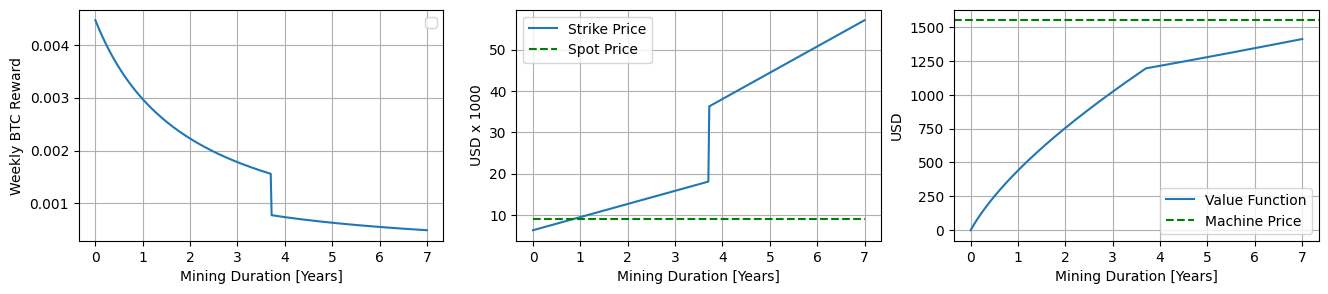

In [31]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 3, 1)
plt.plot(m_usd_bsm._option_df.ttm, m_usd_bsm._option_df.reward)
plt.xlabel("Mining Duration [Years]")
plt.ylabel("Weekly BTC Reward")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(m_usd_bsm._option_df.ttm, m_usd_bsm._option_df.strike/1000, label="Strike Price")
plt.plot(m_usd_bsm._option_df.ttm, m_usd_bsm._option_df.spot/1000, ls="--", color="green", label="Spot Price")
plt.xlabel("Mining Duration [Years]")
plt.ylabel("USD x 1000")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(m_usd_bsm._option_df.ttm, m_usd_bsm._option_df.reward_value.cumsum(), label="Value Function")
plt.axhline(1550.0, ls="--", label="Machine Price", color="green")
plt.xlabel("Mining Duration [Years]")
plt.ylabel("USD")
plt.legend()
plt.grid()



In [36]:
idx = m_usd_bsm._option_df.reward_value.cumsum() < m_usd_bsm._option_df.reward_value.sum() * 0.75
m_usd_bsm._option_df.ttm[idx].max()

3.1239669421487606